# Simulation of Neural Tuning Curve Data

This notebook generates synthetic neural data representative of a classical tuning curve experiment, commonly used in systems neuroscience to characterize stimulus-response properties of individual neurons.


Specifically, I simulate the firing rate of a neuron in response to various stimulus orientations using a parametric model of orientation selectivity. The resulting dataset will later be used for Bayesian parameter inference via nested sampling (PyMultiNest), in the separate analysis notebook fitting.ipynb.



**Background**

Tuning curves describe how a neuron's firing rate varies as a function of a particular stimulus feature. In the case of orientation selectivity, neurons in primary visual cortex exhibit Gaussian-like response profiles centered around their preferred orientation. A widely used parametric form of the tuning curve is:
$$
f(s) = r_{\rm max} \, \exp\left(-\frac{(s - s_{\rm max})^2}{2\sigma_f^2}\right) + \varepsilon\, ,
$$
where:
- $ f(s) $ is the firing rate in response to stimulus angle $s$,
- $ r_{\rm max} $ is the maximum firing rate (amplitude),
- $ s_{\rm max} $ is the preferred stimulus orientation (degrees),
- $ \sigma_f $ is the tuning width (degree of selectivity),
- $ \varepsilon \sim \mathcal{N}(0, \sigma_{\text{noise}}^2) $ represents observation noise.

This modeling approach is consistent with widely accepted representations of neuronal encoding, particularly in early sensory areas.



**Implementation Details**

- Stimulus orientations are sampled uniformly in the range $[-50^\circ, 50^\circ]$.
- The noise-free firing rate is generated using a Gaussian tuning curve.
- Additive Gaussian noise simulates biological and measurement variability.
- The final dataset includes stimulus angle, observed response, and estimated noise level.

A CSV file containing the simulated dataset is created, with the following columns:
- `s`: stimulus orientation (in degrees),
- `response`: observed firing rate (in Hz),
- `error`: standard deviation of the added Gaussian noise (in Hz).





References:
- for neural tuning: Dayan, P., & Abbott, L. F. (2001). *Theoretical Neuroscience: Computational and Mathematical Modeling of Neural Systems*. MIT Press;
- for nested sampling and pymultinest: Buchner et al. 2014, A&A.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

# ---- Parameters ----
r_max_true = 52         # Peak firing rate (Hz)
s_max_true = 0         # Preferred stimulus (centered at 0°)
sigma_f_true = 15     # Tuning width (selective neuron)
noise_std = 2.0     # Noise level (Hz)
csv_file = "tuning_data.csv" 
n_points = 30
s_range = (-50, 50)


# ---- High-resolution s for simulated true curve ----
s_true = np.linspace(-90, 90, 800)  
# ---- Stimulus points (measurements) ----
s_points = np.linspace(-50, 50, 30)   # experiment trials

# ---- Tuning curve function ----
def tuning_curve(s, r_max, s_max, sigma_f):
    return r_max * np.exp(-0.5 * ((s - s_max) / sigma_f)**2)


# --- Simulation Function ---
def simulate_tuning_data(n_points=30, noise_std=2.0, 
                         r_max=20, s_max=0, sigma_f=15, 
                         s_range=(-50, 50), 
                         seed=42):
    np.random.seed(seed)
    
    s = np.linspace(s_range[0], s_range[1], n_points)
    response_clean = tuning_curve(s, r_max, s_max, sigma_f)
    response_noisy = response_clean + np.random.normal(0, noise_std, size=s.shape)
    
    df = pd.DataFrame({
        "s": s,
        "response": response_noisy,
        "error": np.full_like(s, noise_std)
    })

    df.to_csv(csv_file, index=False)
    
    return df


Below, it is shown the simulated neural tuning curve and data with errors.

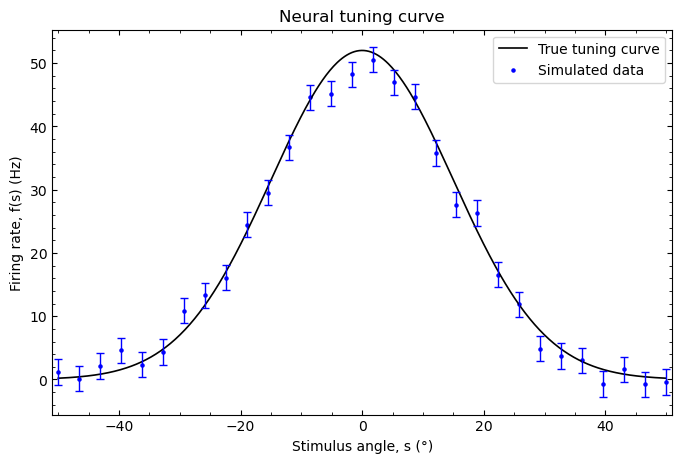

In [3]:
s_true = np.linspace(s_range[0], s_range[1], 500)
response_true = tuning_curve(s_true, r_max_true, s_max_true, sigma_f_true)


df = simulate_tuning_data(n_points, noise_std, r_max_true, s_max_true, sigma_f_true, s_range)


# ---- Plot ----
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(s_true, response_true, lw=1.2, color='black', label='True tuning curve')
ax.scatter(df['s'], df['response'], s=5, color='blue', label='Simulated data')
ax.errorbar(df['s'], df['response'], yerr=df['error'], fmt='None', color='blue', capsize=3, elinewidth=1)

ax.set_xlabel('Stimulus angle, s (°)')
ax.set_ylabel('Firing rate, f(s) (Hz)')
ax.set_title('Neural tuning curve')
ax.legend()
ax.set_xlim(-51, 51)

# Customize ticks on all four axis
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

# Add minor ticks
ax.minorticks_on()

# Optionally control the spacing of minor ticks
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.show()
